# Lab 5

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/giswqs/geog-312/blob/main/book/labs/lab_05.ipynb)

## Objective

This lab introduces you to essential GIS raster operations using Python's rasterio and matplotlib libraries. By the end of this lab, you will have learned to:

- Read and explore raster data files.
- Visualize and manipulate single-band and multi-band rasters.
- Perform basic raster operations such as clipping, band math, and reprojection.
- Work with Digital Elevation Models (DEMs) and multispectral satellite imagery.

## Required Libraries

Make sure you have the following libraries installed:

In [ ]:
# %pip install rasterio matplotlib numpy

## Sample Datasets

- Singlg-band image (DEM): https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif
- Multispectral image (Landsat): https://github.com/opengeos/datasets/releases/download/raster/cog.tif

## Exercise 1: Reading and Exploring Raster Data

1. Open the single-band DEM image using `rasterio`.
2. Retrieve and print the raster metadata, including the CRS, resolution, bounds, number of bands, and data types.
3. Display the raster’s width, height, and pixel data types to understand the grid dimensions and data structure.

In [1]:
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
import numpy as np


src_path = "https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif"
multi_band_path = "https://github.com/opengeos/datasets/releases/download/raster/cog.tif"

src= rasterio.open(src_path)
print(f"Width: {src.width}, Height: {src.height}, Bands: {src.count}")
print(f"Bounds: {src.bounds}")
print(f"Coordinate Reference System: {src.crs}")
print(src.meta)

Width: 4269, Height: 3113, Bands: 1
Bounds: BoundingBox(left=-13442488.3428, bottom=4388214.6777, right=-13058278.3428, top=4668371.5775)
Coordinate Reference System: EPSG:3857
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4269, 'height': 3113, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(90.0, 0.0, -13442488.3428,
       0.0, -89.99579177642138, 4668371.5775)}


## Exercise 2: Visualizing and Manipulating Raster Bands

1. Visualize the single-band DEM using a custom colormap (e.g., cmap='terrain').
2. Open the multispectral image and visualize the first band using a suitable colormap.
3. Combine multiple bands from the multispectral image (e.g., Red, Green, and Blue) and stack them to create an RGB composite image.

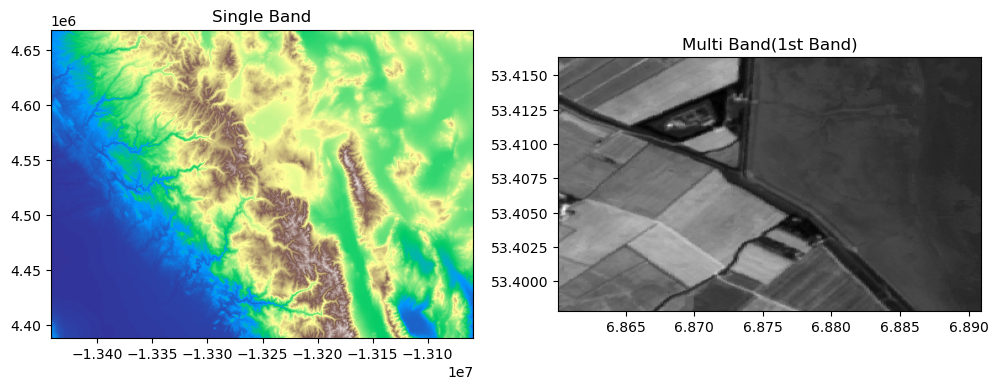

In [3]:
multi_band_src = rasterio.open(multi_band_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title("Single Band")
rasterio.plot.show(src, cmap='terrain', ax=ax[0])
ax[1].set_title("Multi Band(1st Band)")
rasterio.plot.show(multi_band_src, cmap='gray', ax=ax[1])
plt.show()


In [20]:
red_band = multi_band_src.read(1)
green_band = multi_band_src.read(3)
blue_band = multi_band_src.read(2)

In [21]:
rgb = np.dstack((red_band, green_band, blue_band))
rgb = ((rgb / rgb.max()) * 255).astype('uint8')

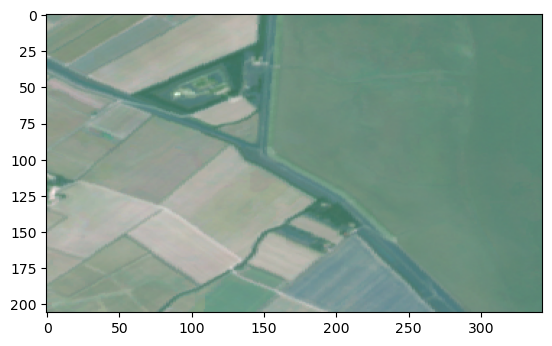

In [22]:
plt.imshow(rgb)

## Exercise 3: Raster Clipping with Array Indexing

1. Open the multispectral image and clip a geographic subset using array indexing (specifying row and column ranges).
2. Visualize the clipped portion of the image using matplotlib to ensure the subset is correct.
3. Save the clipped raster subset to a new file named `clipped_multispectral.tif`.

In [23]:
subset = multi_band_src.read()
subset.shape

(4, 206, 343)

In [24]:
clipping = subset[:, 50:150, 100:200]
clipping.shape

(4, 100, 100)

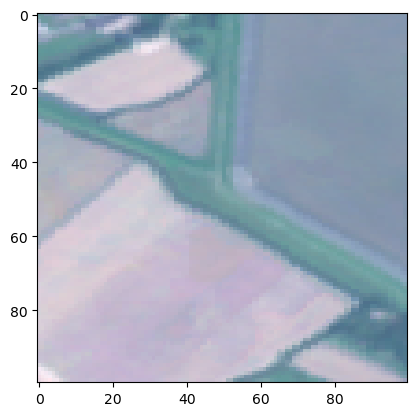

In [26]:
clip_stack = np.dstack((clipping[0], clipping[1], clipping[2]))
clip_stack = ((clip_stack / clip_stack.max()) * 255).astype('uint8')
plt.imshow(clip_stack)

In [27]:
import rasterio.transform

window_bounds = rasterio.windows.bounds(rasterio.windows.Window(100, 50, 100, 100), multi_band_src.transform)
new_transform = rasterio.transform.from_bounds(*window_bounds, 100, 100)

with rasterio.open(
  "clipped_multispectral.tif",
  "w",
  driver="GTiff",
  width=clipping.shape[2],
  height=clipping.shape[1],
  count=clipping.shape[0],
  dtype=clipping.dtype,
  crs=multi_band_src.crs,
  transform=new_transform,
  compress="lzw"
  ) as dst:
  dst.write(clipping)

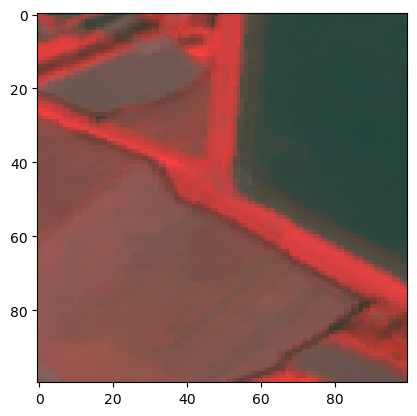

In [28]:
with rasterio.open("clipped_multispectral.tif") as clipped_src:
  clipped_data = clipped_src.read()
  rgb_subset = np.dstack((clipped_data[3], clipped_data[2], clipped_data[1]))
  rgb_subset = (rgb_subset / rgb_subset.max()) * 255
  rgb_subset = rgb_subset.astype(np.uint8)
  plt.imshow(rgb_subset)

## Exercise 4: Calculating NDWI (Band Math)

1. Open the multispectral image and extract the Green and Near-Infrared (NIR) bands. This multispectral image has the following band order:
   - Band 2: Blue
   - Band 3: Green
   - Band 4: Red
   - Band 5: NIR
2. Compute the Normalized Difference Water Index ([NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index)) using the formula:

    NDWI= (Green - NIR) / (Green + NIR)

3. Visualize the NDWI result using a water-friendly colormap (e.g., cmap='Blues') to highlight water bodies.
4. Save the resulting NDWI image as a new raster file named ndwi.tif.

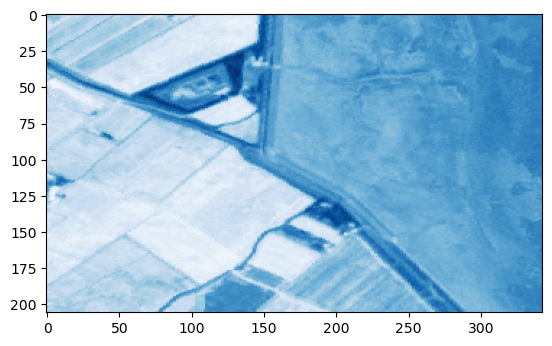

In [29]:
green_band = multi_band_src.read(3)
nir_band = multi_band_src.read(1)

ndwi = (green_band - nir_band) / (green_band + nir_band)
#ndwi = ((ndwi / ndwi.max()) * 255).astype('uint8')
plt.imshow(ndwi, cmap='Blues')


In [31]:

updated_profile = multi_band_src.profile
updated_profile.update(
  dtype=rasterio.float32,
  count=1,
  compress="lzw"
)

output_path = "ndwi.tif"
with rasterio.open(output_path, "w", **updated_profile) as dst:
  dst.write(ndwi, 1)
print(f"Raster data has been written to {output_path}")

Raster data has been written to ndwi.tif


## Exercise 5: Reprojecting Raster Data

1. Reproject the single-band DEM raster from its original CRS to EPSG:4326 (WGS 84) using the `rasterio.warp.reproject` function.
2. Save the reprojected raster to a new GeoTIFF file named `reprojected_dem.tif`.
3. Visualize both the original and reprojected DEM datasets to compare how the reprojection affects the spatial coverage and resolution.

In [32]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
dst_crs = "EPSG:4326"
output_path = "reprojected_dem.tif"

with rasterio.open(src_path) as src:
  transform, width, height = calculate_default_transform(
    src.crs, dst_crs, src.width, src.height, *src.bounds
  )

  profile = src.profile
  profile.update(
    crs=dst_crs,
    transform=transform,
    width=width,
    height=height
  )

  with rasterio.open(output_path, "w", **profile) as dst:
    for i in range(1, src.count + 1):
      reproject(
        source=rasterio.band(src, i),
        destination=rasterio.band(dst, i),
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
      )
print(f"Raster data has been written to {output_path}")

Raster data has been written to reprojected_dem.tif


{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4269, 'height': 3113, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(90.0, 0.0, -13442488.3428,
       0.0, -89.99579177642138, 4668371.5775)}
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4575, 'height': 2642, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0007543273324700005, 0.0, -120.75592734935736,
       0.0, -0.0007543273324700005, 38.62692343418839)}


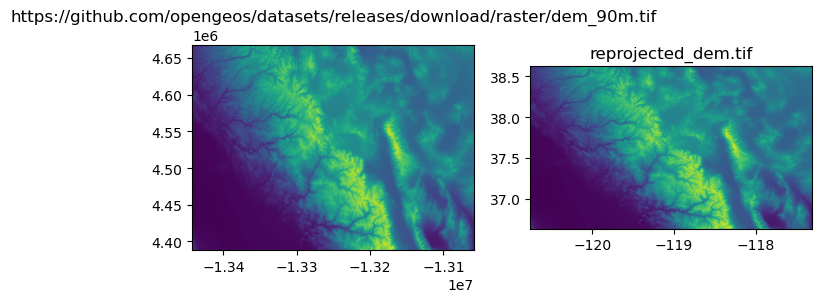

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
axes = ax.flatten()

for i, path in enumerate([src_path, output_path]):
  with rasterio.open(path) as src:
    axes[i].set_title(path)
    rasterio.plot.show(src, ax=axes[i])
    print(src.meta)